In [2]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import rcParams
from projectaria_tools.core import mps
from projectaria_tools.core import data_provider
from projectaria_tools.core import calibration
from projectaria_tools.core.calibration import CameraCalibration, KANNALA_BRANDT_K3


rcParams["figure.figsize"] = 16, 32

import json
import os
import random

import av
import pandas as pd
from PIL import Image, ImageDraw
from tqdm.auto import tqdm

# Loads dataframe at target path to csv
def load_csv_to_df(filepath: str) -> pd.DataFrame:
    with open(filepath, "r") as csv_file:
        return pd.read_csv(csv_file)

## Visualization Utils

In [3]:
palette = np.array(
        [
            [255, 128, 0],
            [255, 153, 51],
            [255, 178, 102],
            [230, 230, 0],
            [255, 153, 255],
            [153, 204, 255],
            [255, 102, 255],
            [255, 51, 255],
            [102, 178, 255],
            [51, 153, 255],
            [255, 153, 153],
            [255, 102, 102],
            [255, 51, 51],
            [153, 255, 153],
            [102, 255, 102],
            [51, 255, 51],
            [0, 255, 0],
            [0, 0, 255],
            [255, 0, 0],
            [255, 255, 255],
        ]
    )

In [4]:
def get_body_metadata():
    keypoints_map = [
        {"label": "Nose", "id": "fee3cbd2", "color": "#f77189"},
        {"label": "Left-eye", "id": "ab12de34", "color": "#d58c32"},
        {"label": "Right-eye", "id": "7f2g1h6k", "color": "#a4a031"},
        {"label": "Left-ear", "id": "mn0pqrst", "color": "#50b131"},
        {"label": "Right-ear", "id": "yz89wx76", "color": "#34ae91"},
        {"label": "Left-shoulder", "id": "5a4b3c2d", "color": "#37abb5"},
        {"label": "Right-shoulder", "id": "e1f2g3h4", "color": "#3ba3ec"},
        {"label": "Left-elbow", "id": "6i7j8k9l", "color": "#bb83f4"},
        {"label": "Right-elbow", "id": "uv0wxy12", "color": "#f564d4"},
        {"label": "Left-wrist", "id": "3z4ab5cd", "color": "#2fd4aa"},
        {"label": "Right-wrist", "id": "efgh6789", "color": "#94d14f"},
        {"label": "Left-hip", "id": "ijklmnop", "color": "#b3d32c"},
        {"label": "Right-hip", "id": "qrstuvwx", "color": "#f9b530"},
        {"label": "Left-knee", "id": "yz012345", "color": "#83f483"},
        {"label": "Right-knee", "id": "6bc7defg", "color": "#32d58c"},
        {"label": "Left-ankle", "id": "hijk8lmn", "color": "#3ba3ec"},
        {"label": "Right-ankle", "id": "opqrs1tu", "color": "#f564d4"},
    ]

    # pyre-ignore
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0]]

    skeleton = [
                [16, 14],
                [14, 12],
                [17, 15],
                [15, 13],
                [12, 13],
                [6, 12],
                [7, 13],
                [6, 7],
                [6, 8],
                [7, 9],
                [8, 10],
                [9, 11],
                [2, 3],
                [1, 2],
                [1, 3],
                [2, 4],
                [3, 5],
                [4, 6],
                [5, 7],
            ]
    return keypoints_map, skeleton, pose_kpt_color

In [5]:
def get_hands_metadata():
    keypoints_map = [
        {"label": "Right_Wrist", "id": "fee3cbd2", "color": "#f77189"},
        {"label": "Right_Thumb_1", "id": "yz012345", "color": "#83f483"},
        {"label": "Right_Thumb_2", "id": "6bc7defg", "color": "#32d58c"},
        {"label": "Right_Thumb_3", "id": "hijk8lmn", "color": "#3ba3ec"},
        {"label": "Right_Thumb_4", "id": "opqrs1tu", "color": "#f564d4"},
        {"label": "Right_Index_1", "id": "ab12de34", "color": "#d58c32"},
        {"label": "Right_Index_2", "id": "7f2g1h6k", "color": "#a4a031"},
        {"label": "Right_Index_3", "id": "mn0pqrst", "color": "#50b131"},
        {"label": "Right_Index_4", "id": "9vwxyzab", "color": "#32d58c"},
        {"label": "Right_Middle_1", "id": "yz89wx76", "color": "#34ae91"},
        {"label": "Right_Middle_2", "id": "5a4b3c2d", "color": "#37abb5"},
        {"label": "Right_Middle_3", "id": "e1f2g3h4", "color": "#3ba3ec"},
        {"label": "Right_Middle_4", "id": "cdefgh23", "color": "#3ba3ec"},
        {"label": "Right_Ring_1", "id": "efgh6789", "color": "#94d14f"},
        {"label": "Right_Ring_2", "id": "ijklmnop", "color": "#b3d32c"},
        {"label": "Right_Ring_3", "id": "qrstuvwx", "color": "#f9b530"},
        {"label": "Right_Ring_4", "id": "ijkl4567", "color": "#bb83f4"},
        {"label": "Right_Pinky_1", "id": "6i7j8k9l", "color": "#bb83f4"},
        {"label": "Right_Pinky_2", "id": "uv0wxy12", "color": "#f564d4"},
        {"label": "Right_Pinky_3", "id": "3z4ab5cd", "color": "#2fd4aa"},
        {"label": "Right_Pinky_4", "id": "mnop8qrs", "color": "#f564d4"},
        {"label": "Left_Wrist", "id": "fee3cbd2_left", "color": "#f77189"},
        {"label": "Left_Thumb_1", "id": "yz012345_left", "color": "#83f483"},
        {"label": "Left_Thumb_2", "id": "6bc7defg_left", "color": "#32d58c"},
        {"label": "Left_Thumb_3", "id": "hijk8lmn_left", "color": "#3ba3ec"},
        {"label": "Left_Thumb_4", "id": "opqrs1tu_left", "color": "#f564d4"},
        {"label": "Left_Index_1", "id": "ab12de34_left", "color": "#d58c32"},
        {"label": "Left_Index_2", "id": "7f2g1h6k_left", "color": "#a4a031"},
        {"label": "Left_Index_3", "id": "mn0pqrst_left", "color": "#50b131"},
        {"label": "Left_Index_4", "id": "9vwxyzab_left", "color": "#32d58c"},
        {"label": "Left_Middle_1", "id": "yz89wx76_left", "color": "#34ae91"},
        {"label": "Left_Middle_2", "id": "5a4b3c2d_left", "color": "#37abb5"},
        {"label": "Left_Middle_3", "id": "e1f2g3h4_left", "color": "#3ba3ec"},
        {"label": "Left_Middle_4", "id": "cdefgh23_left", "color": "#3ba3ec"},
        {"label": "Left_Ring_1", "id": "efgh6789_left", "color": "#94d14f"},
        {"label": "Left_Ring_2", "id": "ijklmnop_left", "color": "#b3d32c"},
        {"label": "Left_Ring_3", "id": "qrstuvwx_left", "color": "#f9b530"},
        {"label": "Left_Ring_4", "id": "ijkl4567_left", "color": "#bb83f4"},
        {"label": "Left_Pinky_1", "id": "6i7j8k9l_left", "color": "#bb83f4"},
        {"label": "Left_Pinky_2", "id": "uv0wxy12_left", "color": "#f564d4"},
        {"label": "Left_Pinky_3", "id": "3z4ab5cd_left", "color": "#2fd4aa"},
        {"label": "Left_Pinky_4", "id": "mnop8qrs_left", "color": "#f564d4"},
    ]

    links = {
        "fee3cbd2": ["ab12de34", "yz89wx76", "6i7j8k9l", "efgh6789", "yz012345"],
        "ab12de34": ["7f2g1h6k"],
        "7f2g1h6k": ["mn0pqrst"],
        "mn0pqrst": ["9vwxyzab"],
        "yz89wx76": ["5a4b3c2d"],
        "5a4b3c2d": ["e1f2g3h4"],
        "e1f2g3h4": ["cdefgh23"],
        "6i7j8k9l": ["uv0wxy12"],
        "uv0wxy12": ["3z4ab5cd"],
        "3z4ab5cd": ["mnop8qrs"],
        "efgh6789": ["ijklmnop"],
        "ijklmnop": ["qrstuvwx"],
        "qrstuvwx": ["ijkl4567"],
        "yz012345": ["6bc7defg"],
        "6bc7defg": ["hijk8lmn"],
        "hijk8lmn": ["opqrs1tu"],
        "fee3cbd2_left": [
            "ab12de34_left",
            "yz89wx76_left",
            "6i7j8k9l_left",
            "efgh6789_left",
            "yz012345_left",
        ],
        "ab12de34_left": ["7f2g1h6k_left"],
        "7f2g1h6k_left": ["mn0pqrst_left"],
        "mn0pqrst_left": ["9vwxyzab_left"],
        "yz89wx76_left": ["5a4b3c2d_left"],
        "5a4b3c2d_left": ["e1f2g3h4_left"],
        "e1f2g3h4_left": ["cdefgh23_left"],
        "6i7j8k9l_left": ["uv0wxy12_left"],
        "uv0wxy12_left": ["3z4ab5cd_left"],
        "3z4ab5cd_left": ["mnop8qrs_left"],
        "efgh6789_left": ["ijklmnop_left"],
        "ijklmnop_left": ["qrstuvwx_left"],
        "qrstuvwx_left": ["ijkl4567_left"],
        "yz012345_left": ["6bc7defg_left"],
        "6bc7defg_left": ["hijk8lmn_left"],
        "hijk8lmn_left": ["opqrs1tu_left"],
    }

    hand_dict = dict()
    for index, kpt in enumerate(keypoints_map):
        hand_dict[kpt["id"]] = index + 1

    skeleton = list()
    for start_point in links:
        end_points = links[start_point]
        for end_point in end_points:
            start_index = hand_dict[start_point]
            end_index = hand_dict[end_point]
            skeleton.append([start_index, end_index])

    klist = [0]
    klist.extend([2] * 4)
    klist.extend([4] * 4)
    klist.extend([6] * 4)
    klist.extend([8] * 4)
    klist.extend([10] * 4)
    klist.extend([0])
    klist.extend([2] * 4)
    klist.extend([4] * 4)
    klist.extend([6] * 4)
    klist.extend([8] * 4)
    klist.extend([10] * 4)

    pose_kpt_color = palette[klist]
    return keypoints_map, skeleton, pose_kpt_color

In [6]:
def get_coords(annot):
    pts = dict()
    for k in annot:
        atype = 1
        if annot[k]["placement"] == "auto":
            atype = 0
        pts[k] = [annot[k]["x"], annot[k]["y"], atype]
    return pts


def draw_skeleton(img, all_pts, skeleton):
    draw = ImageDraw.Draw(img)
    for item in skeleton:
        left_index = item[0] - 1
        right_index = item[1] - 1
        left_pt = all_pts[left_index]
        right_pt = all_pts[right_index]
        if len(left_pt) == 0 or len(right_pt) == 0:
            continue
        draw.line([left_pt, right_pt], fill="white", width=10)


def draw_cross(img, x, y, color):
    draw = ImageDraw.Draw(img)
    # Circle parameters
    center = (x, y)  # Center of the cross
    cross_length = 10  # Half-length of the cross arms
    # Calculate the end points of the cross
    left_point = (center[0] - cross_length, center[1])
    right_point = (center[0] + cross_length, center[1])
    top_point = (center[0], center[1] - cross_length)
    bottom_point = (center[0], center[1] + cross_length)

    # Draw the horizontal line
    draw.line([left_point, right_point], fill=color, width=3)
    # Draw the vertical line
    draw.line([top_point, bottom_point], fill=color, width=3)


def draw_circle(img, x, y, color):
    draw = ImageDraw.Draw(img)
    # Circle parameters
    center = (x, y)  # Center of the circle
    radius = 12  # Radius of the circle

    # Calculate the bounding box of the circle
    left_up_point = (center[0] - radius, center[1] - radius)
    right_down_point = (center[0] + radius, center[1] + radius)

    # Draw the circle with a black outline
    draw.ellipse(
        [left_up_point, right_down_point], outline=(255, 255, 255), fill=color, width=6
    )


def draw_skeleton_hands(img, all_pts, skeleton, ratio=1):
    draw = ImageDraw.Draw(img)
    for item in skeleton:
        left_index = item[0] - 1
        right_index = item[1] - 1
        left_pt = all_pts[left_index]
        right_pt = all_pts[right_index]
        if len(left_pt) == 0 or len(right_pt) == 0:
            continue        
        draw.line([left_pt, right_pt], fill="white", width=int(ratio*4))


def draw_circle_hands(img, x, y, color, ratio=1):
    draw = ImageDraw.Draw(img)
    # Circle parameters
    center = (x, y)  # Center of the circle
    radius = int(ratio*8)  # Radius of the circle

    # Calculate the bounding box of the circle
    left_up_point = (center[0] - radius, center[1] - radius)
    right_down_point = (center[0] + radius, center[1] + radius)

    # Draw the circle with a black outline
    draw.ellipse(
        [left_up_point, right_down_point], outline=(255, 255, 255), fill=color, width=int(ratio*4)
    )

def draw_cross_hands(img, x, y, color, ratio=1):
    draw = ImageDraw.Draw(img)
    # Circle parameters
    center = (x, y)  # Center of the cross
    cross_length = int(ratio*8)  # Half-length of the cross arms
    # Calculate the end points of the cross
    left_point = (center[0] - cross_length, center[1])
    right_point = (center[0] + cross_length, center[1])
    top_point = (center[0], center[1] - cross_length)
    bottom_point = (center[0], center[1] + cross_length)

    # Draw the horizontal line
    draw.line([left_point, right_point], fill=color, width=int(ratio*4))
    # Draw the vertical line
    draw.line([top_point, bottom_point], fill=color, width=int(ratio*4))


def show_results(results):
    for cam_name in results:
        img = results[cam_name]
        plt.figure()
        plt.imshow(img)
        plt.axis("off")  # Hide the axes ticks
        plt.title(f"{cam_name}")
        plt.show()

In [7]:
def get_viz(pil_img, keypoints_map, ann, skeleton, pose_kpt_color, annot_type='body', is_aria=False):
    pts = get_coords(ann)
    ratio = 1
    if is_aria:
        ratio = 0.5           
    
    all_pts = list()
    for index, keypoints in enumerate(keypoints_map):
        kpname = keypoints["label"].lower()
        
        if kpname in pts:          
            x, y = pts[kpname][0], pts[kpname][1]
            all_pts.append((x, y))                
        else:
            all_pts.append(())

    if annot_type=='body':
        draw_skeleton(pil_img, all_pts, skeleton)
    else:
        draw_skeleton_hands(pil_img, all_pts, skeleton, ratio)

    for index, keypoints in enumerate(keypoints_map):
        kpname = keypoints["label"].lower()
        if kpname in pts:            
            x, y, pt_type = pts[kpname][0], pts[kpname][1], pts[kpname][2]
            color = tuple(pose_kpt_color[index])
            if pt_type == 1:
                if annot_type=='body':
                    draw_circle(pil_img, x, y, color)
                else:
                    draw_circle_hands(pil_img, x, y, color, ratio)                    
            else:
                if annot_type=='body':
                    draw_cross(pil_img, x, y, color)
                else:
                    draw_cross_hands(pil_img, x, y, color, ratio)
                
        else:
            pass
    return pil_img            

## Video Utilities

In [8]:
def get_frame(video_local_path, frame_idx):
    container = av.open(video_local_path)
    print(container.streams.video[0].frames)
    frame_count = 0
    for frame in tqdm(container.decode(video=0)):
        if frame_count == frame_idx:
            input_img = np.array(frame.to_image())            
            pil_img = Image.fromarray(input_img)
            print(frame_count)
            return pil_img
        frame_count+=1    

## Load Take Info and Trajectory Data

In [9]:
release_dir = "/datasets01/egoexo4d/v2/"
annotation_dir = os.path.join(release_dir, "annotations/")

egoexo = {
    "takes": os.path.join(release_dir, "takes.json"),
    "captures": os.path.join(release_dir, "captures.json"),
    "physical_setting": os.path.join(release_dir, "physical_setting.json"),
    "participants": os.path.join(release_dir, "participants.json"),
    "visual_objects": os.path.join(release_dir, "visual_objects.json"),
    "metadata": os.path.join(release_dir, "metadata.json"),
}

egoexo_pd = {}
for k, v in egoexo.items():
    egoexo_pd[k] = pd.read_json(open(v))

for k, v in egoexo.items():
    egoexo[k] = json.load(open(v))

takes = egoexo["takes"]
captures = egoexo["captures"]
takes_by_uid = {x["take_uid"]: x for x in takes}

In [10]:
# annotation type can be hand or body
#annotation_type = "hand" 
#take_uid = "23ff1c48-01ea-4d34-a38b-bc96e767b9b9" #Piano
#take_uid = "02715c86-e30c-4791-92b7-38b488e51aba"  # Bike

In [11]:
annotation_type = "body"
#take_uid = "cb4a441d-0dae-4bec-90e3-1b9dab39e269" #Basketball
#take_uid = "fad811da-e457-4d2a-8cf4-c3a09c11a41a"  # Dance
take_uid = "0bc47e29-e086-4726-b874-f89671366f06"  # Violin


In [12]:
if annotation_type == "body":
    keypoints_map, skeleton, pose_kpt_color = get_body_metadata()
else:
    keypoints_map, skeleton, pose_kpt_color = get_hands_metadata()

In [13]:
take = [take for take in egoexo["takes"] if take["take_uid"] == take_uid]
take = take[0]

In [14]:
# Initialize exo cameras from calibration file since sometimes some exo camera is missing
traj_dir = os.path.join(release_dir, take["root_dir"], "trajectory")
exo_traj_path = os.path.join(traj_dir, "gopro_calibs.csv")

exo_traj_df = load_csv_to_df(exo_traj_path)
exo_cam_names = list(exo_traj_df["cam_uid"])
ego_cam_names = [x["cam_id"] for x in take["capture"]["cameras"] if x["is_ego"] and x["cam_id"].startswith("aria")]
all_cams = ego_cam_names + exo_cam_names
ego_cam_name = ego_cam_names[0]
exo_cam_names, ego_cam_name

(['gp01', 'gp02', 'gp03', 'gp04', 'gp06'], 'aria01')

In [15]:
aria_dir = os.path.join(release_dir, take["root_dir"])
aria_path = os.path.join(aria_dir, f"{ego_cam_name}.vrs")
print(aria_path)
vrs_data_provider = data_provider.create_vrs_data_provider(aria_path)

/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/aria01.vrs


[ProgressLogger][INFO]: 2024-12-13 23:55:59: Opening /datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/aria01.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/aria01.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


## Load EgoPose Annotations

In [16]:
assert annotation_type in ["body", "hand"]
egopose_ann_dir = os.path.join(
    annotation_dir, f"ego_pose/train/{annotation_type}/annotation"
)
# egopose_pseudo_dir = os.path.join(annotation_dir, f"ego_pose/train/{annotation_type}/automatic")
egopose_camera_dir = os.path.join(annotation_dir, f"ego_pose/train/camera_pose/")
# egopose is self-contained and has camera params that are necessary to use the annotations, please refer to the camera dir
camera_info_path = os.path.join(egopose_camera_dir, f"{take_uid}.json")
camera_info = json.load(open(camera_info_path))
annotation_file_path = os.path.join(egopose_ann_dir, f"{take_uid}.json")
annotation = json.load(open(annotation_file_path))
annotation.keys()
frame_idx = random.sample(list(annotation.keys()), 1)[0]
annotation = annotation[frame_idx][0]
frame_idx = int(frame_idx)

## Read frame from exocentric video

In [17]:
base_directory = traj_dir = os.path.join(release_dir, take["root_dir"])
videos = {}
for cam_name in all_cams:
    if cam_name in exo_cam_names:
        stream_name = '0'
    else:
        stream_name = 'rgb'
        
    local_path = os.path.join(base_directory, take['frame_aligned_videos'][cam_name][stream_name]['relative_path'])  
    print(local_path)    
    videos[cam_name] = get_frame(local_path, frame_idx)    

/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/aria01_214-1.mp4
8872


0it [00:00, ?it/s]

2823
/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/gp01.mp4
8872


0it [00:00, ?it/s]

2823
/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/gp02.mp4
8872


0it [00:00, ?it/s]

2823
/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/gp03.mp4
8872


0it [00:00, ?it/s]

2823
/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/gp04.mp4
8872


0it [00:00, ?it/s]

2823
/datasets01/egoexo4d/v2/takes/upenn_0722_Violin_1_3/frame_aligned_videos/gp06.mp4
8872


0it [00:00, ?it/s]

2823


### Read camera intrinsics and extrinsics from gopro_calibs.csv

In [18]:
go_pro_proxy = []
static_calibrations = mps.read_static_camera_calibrations(exo_traj_path)
for static_calibration in static_calibrations:
    # assert the GoPro was correctly localized
    if static_calibration.quality != 1.0:
        print(f"Camera: {static_calibration.camera_uid} was not localized, ignoring this camera.")
        continue
    proxy = {}
    proxy["name"] = static_calibration.camera_uid
#    proxy["image"] = zeros = np.zeros((static_calibration.height, static_calibration.width))
    proxy["pose"] = static_calibration.transform_world_cam
    proxy["camera"] = CameraCalibration(
                            static_calibration.camera_uid,
                            KANNALA_BRANDT_K3,
                            static_calibration.intrinsics,
                            static_calibration.transform_world_cam,
                            static_calibration.width,
                            static_calibration.height,
                            None,
                            math.pi,
                            "")

    go_pro_proxy.append(proxy)

Loaded #StaticCameraCalibration data: 5
Camera: gp01 was not localized, ignoring this camera.


## Get 3D annotation of the frame and project it to exocentric view based on the VRS camera intrinsics

In [19]:
annot_3d = annotation["annotation3D"]['nose']
annot_3d = [annot_3d['x'], annot_3d['y'], annot_3d['z']]
per_go_pro_reprojection = {}
for go_pro in go_pro_proxy:

    pose_vector_in_world = annot_3d
    pose_in_go_pro_world = go_pro["pose"].inverse() @ pose_vector_in_world

    device_projection = go_pro["camera"].project(pose_in_go_pro_world)
    print(device_projection)
    if device_projection is not None:
        if go_pro['name'] not in per_go_pro_reprojection.keys():
            per_go_pro_reprojection[go_pro['name']] = []
        per_go_pro_reprojection[go_pro['name']].append(device_projection)
    else:
        if go_pro['name'] not in per_go_pro_reprojection.keys():
            per_go_pro_reprojection[go_pro['name']] = []
        per_go_pro_reprojection[go_pro['name']].append(None)

frames_with_points = {}
for go_pro in per_go_pro_reprojection:
    frame = videos[go_pro]
    
    if per_go_pro_reprojection[go_pro][0] is not None:
        point_x, point_y = per_go_pro_reprojection[go_pro][0]
        img = frame.copy()
        # Draw a point on the image
        draw = ImageDraw.Draw(img)
        draw.ellipse((point_x-20, point_y-20, point_x+20, point_y+20), fill=(0, 255, 0))
        # Append the frame with point to the list
        frames_with_points[go_pro] = img
    else:
        frames_with_points[go_pro] = np.array(frame)
    

[1826.44564735  989.31092528]
[1756.31701037  852.81972183]
[2100.41726862  647.69992624]
[2231.62102404 1268.31641479]


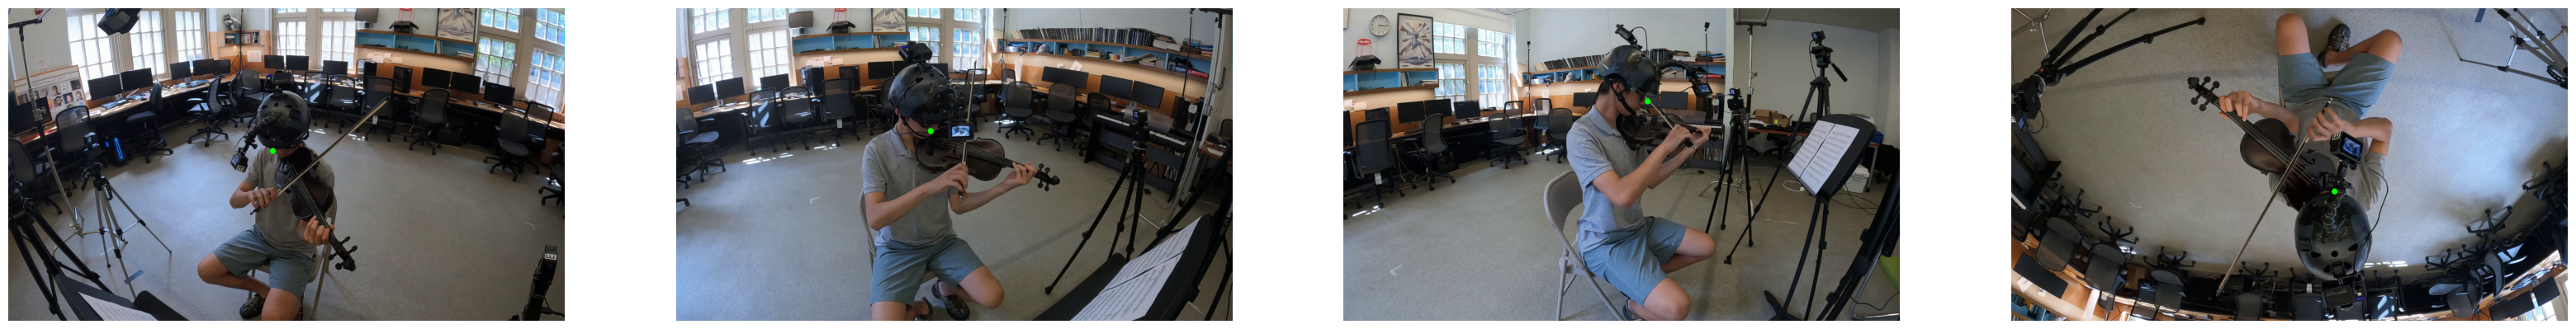

In [20]:
keys = list(frames_with_points.keys())
f, axarr = plt.subplots(1,len(keys), figsize=(40, 10))
for i, ax in enumerate(axarr.flat):
    ax.imshow(frames_with_points[keys[i]], cmap='gray')
    ax.axis('off')

### Read camera intrinsics and extrinsics from camera pose .json

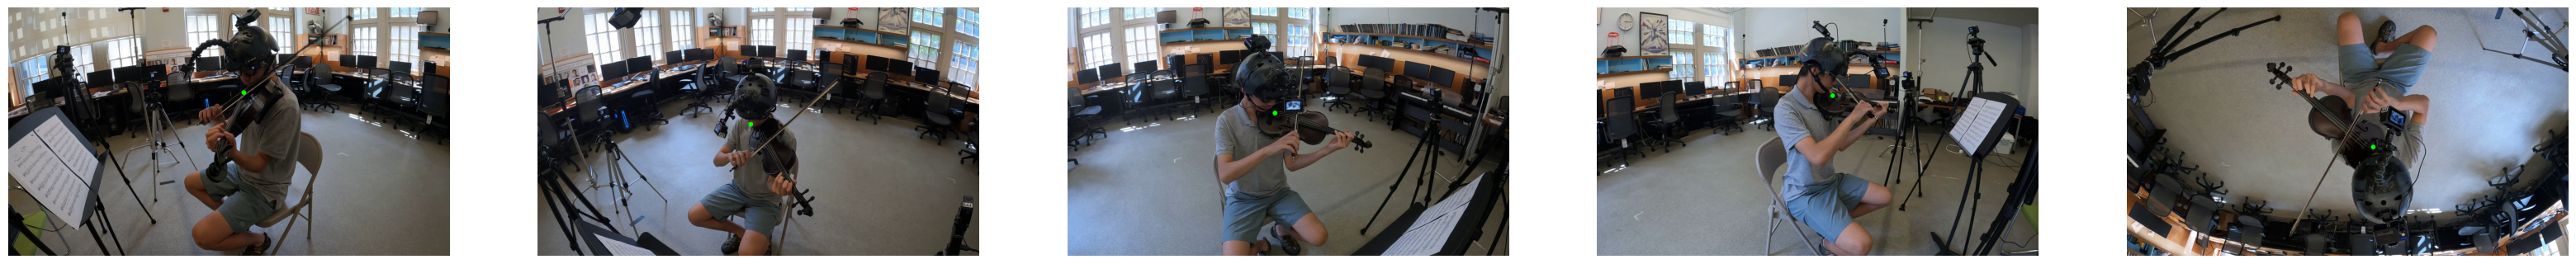

In [21]:
per_go_pro_reprojection = {}
for cam in camera_info:
    if cam in exo_cam_names:
        # read camera intrinsics and extrinsics from json file
        camera_intrinsics = np.array(camera_info[cam]['camera_intrinsics']) #(3,3)
        camera_extrinsics = np.array(camera_info[cam]['camera_extrinsics']) #(3,4)
        
        pose_vector_in_world = np.append(annot_3d, 1)
        pose_in_go_pro_world = np.dot(camera_extrinsics, pose_vector_in_world)

        pose_in_go_pro_world = pose_in_go_pro_world.reshape(3,1)

        device_projection = camera_intrinsics @ pose_in_go_pro_world
        device_projection = device_projection[:2] / device_projection[2]
        device_projection = device_projection.reshape(2)
        
        if device_projection is not None:
            if cam not in per_go_pro_reprojection.keys():
                per_go_pro_reprojection[cam] = []
            per_go_pro_reprojection[cam].append(device_projection)
        else:
            if cam not in per_go_pro_reprojection.keys():
                per_go_pro_reprojection[cam] = []
            per_go_pro_reprojection[cam].append(None)


frames_with_points = {}
for cam in camera_info:
    if cam in exo_cam_names:
        frame = videos[cam]
        
        if per_go_pro_reprojection[cam][0] is not None:
            point_x, point_y = per_go_pro_reprojection[cam][0]
            img = frame.copy()
            # Draw a point on the image
            draw = ImageDraw.Draw(img)
            draw.ellipse((point_x-20, point_y-20, point_x+20, point_y+20), fill=(0, 255, 0))
            # Append the frame with point to the list
            frames_with_points[cam] = img
        else:
            frames_with_points[cam] = np.array(frame)

keys = list(frames_with_points.keys())
f, axarr = plt.subplots(1,len(keys), figsize=(40, 10))
for i, ax in enumerate(axarr.flat):
    ax.imshow(frames_with_points[keys[i]], cmap='gray')
    ax.axis('off')